<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])
print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [33]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
boston = pd.concat([y, X], axis=1)
del boston['B']
boston.describe(include='all')

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000


In [34]:
type(boston)

pandas.core.frame.DataFrame

In [35]:
boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33


In [36]:
boston.index

RangeIndex(start=0, stop=506, step=1)

In [37]:
boston.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
LSTAT      float64
dtype: object

In [38]:
boston.shape

(506, 13)

In [39]:
boston.values

array([[2.4000e+01, 6.3200e-03, 1.8000e+01, ..., 2.9600e+02, 1.5300e+01,
        4.9800e+00],
       [2.1600e+01, 2.7310e-02, 0.0000e+00, ..., 2.4200e+02, 1.7800e+01,
        9.1400e+00],
       [3.4700e+01, 2.7290e-02, 0.0000e+00, ..., 2.4200e+02, 1.7800e+01,
        4.0300e+00],
       ...,
       [2.3900e+01, 6.0760e-02, 0.0000e+00, ..., 2.7300e+02, 2.1000e+01,
        5.6400e+00],
       [2.2000e+01, 1.0959e-01, 0.0000e+00, ..., 2.7300e+02, 2.1000e+01,
        6.4800e+00],
       [1.1900e+01, 4.7410e-02, 0.0000e+00, ..., 2.7300e+02, 2.1000e+01,
        7.8800e+00]])

In [40]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
MEDV       506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [41]:
boston.CRIM.value_counts()

14.33370    2
0.01501     2
0.08265     1
0.97617     1
0.14103     1
0.03502     1
0.03615     1
0.66351     1
0.12650     1
0.10469     1
0.25356     1
0.10000     1
0.05515     1
0.11027     1
4.26131     1
0.34109     1
22.59710    1
0.28955     1
4.34879     1
0.10574     1
3.47428     1
0.02009     1
0.14866     1
5.66637     1
15.87440    1
0.04297     1
0.78570     1
0.29090     1
1.23247     1
2.44953     1
           ..
9.18702     1
0.05602     1
1.83377     1
15.86030    1
7.67202     1
51.13580    1
15.17720    1
8.05579     1
10.06230    1
41.52920    1
0.32264     1
0.04379     1
0.22212     1
0.13117     1
0.51183     1
6.28807     1
0.08826     1
24.80170    1
0.09065     1
23.64820    1
3.56868     1
12.80230    1
0.72580     1
0.03113     1
13.67810    1
0.88125     1
0.01951     1
0.49298     1
0.26838     1
0.03578     1
Name: CRIM, Length: 504, dtype: int64

In [42]:
boston.ZN.value_counts()

0.0      372
20.0      21
80.0      15
12.5      10
22.0      10
25.0      10
40.0       7
45.0       6
30.0       6
90.0       5
21.0       4
95.0       4
60.0       4
33.0       4
75.0       3
35.0       3
28.0       3
55.0       3
52.5       3
70.0       3
34.0       3
85.0       2
82.5       2
17.5       1
100.0      1
18.0       1
Name: ZN, dtype: int64

In [43]:
boston.INDUS.value_counts()

18.10    132
19.58     30
8.14      22
6.20      18
21.89     15
9.90      12
3.97      12
8.56      11
10.59     11
5.86      10
10.01      9
6.91       9
7.38       8
2.46       8
5.19       8
9.69       8
7.87       7
25.65      7
2.18       7
4.05       7
5.13       6
3.44       6
12.83      6
4.93       6
13.92      5
6.96       5
27.74      5
11.93      5
2.89       5
6.41       5
        ... 
2.03       2
7.07       2
1.91       2
2.93       2
6.06       2
1.47       2
3.37       2
1.69       2
2.95       2
1.25       2
3.64       2
3.78       2
2.68       2
4.39       2
1.38       1
2.97       1
2.25       1
3.75       1
1.89       1
1.22       1
1.32       1
0.74       1
1.76       1
2.31       1
0.46       1
1.21       1
4.15       1
2.02       1
2.01       1
4.00       1
Name: INDUS, Length: 76, dtype: int64

In [44]:
boston.CHAS.value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

In [45]:
boston.NOX.value_counts()

0.5380    23
0.7130    18
0.4370    17
0.8710    16
0.4890    15
0.6240    15
0.6930    14
0.6050    14
0.7400    13
0.5440    12
0.7000    11
0.5200    11
0.6470    10
0.5070    10
0.4310    10
0.4480     9
0.5470     9
0.4880     8
0.4640     8
0.4930     8
0.7700     8
0.4280     8
0.5040     8
0.5850     8
0.5840     8
0.5150     8
0.6790     8
0.5240     7
0.5810     7
0.6140     7
          ..
0.4429     4
0.4000     4
0.4050     3
0.4100     3
0.6550     3
0.4090     3
0.4290     3
0.4580     3
0.4330     3
0.4040     3
0.6680     3
0.4161     3
0.4010     3
0.4030     3
0.4600     3
0.4420     3
0.5750     2
0.3980     2
0.4690     2
0.4840     2
0.3920     2
0.4150     2
0.6590     2
0.4379     2
0.4350     1
0.3850     1
0.3940     1
0.5180     1
0.4220     1
0.3890     1
Name: NOX, Length: 81, dtype: int64

In [46]:
boston.RM.value_counts()

6.167    3
6.229    3
6.127    3
5.713    3
6.417    3
6.405    3
6.380    2
5.304    2
5.983    2
7.185    2
5.856    2
6.968    2
7.820    2
5.936    2
6.030    2
6.251    2
6.431    2
6.727    2
6.004    2
6.185    2
6.193    2
6.495    2
5.757    2
6.782    2
6.951    2
5.404    2
6.009    2
6.794    2
6.315    2
5.935    2
        ..
6.112    1
6.006    1
7.147    1
5.468    1
5.707    1
7.267    1
6.800    1
5.818    1
6.430    1
6.762    1
6.593    1
7.178    1
5.570    1
5.884    1
6.471    1
7.107    1
6.382    1
6.575    1
7.287    1
5.898    1
5.403    1
8.266    1
6.101    1
5.093    1
5.036    1
6.552    1
4.368    1
6.174    1
6.701    1
6.625    1
Name: RM, Length: 446, dtype: int64

In [47]:
boston.AGE.value_counts()

100.0    43
96.0      4
98.2      4
95.4      4
97.9      4
87.9      4
98.8      4
94.1      3
88.0      3
21.4      3
96.2      3
98.9      3
97.3      3
32.2      3
97.0      3
92.6      3
36.6      3
97.4      3
95.6      3
76.5      3
94.5      2
91.9      2
6.6       2
77.7      2
18.5      2
21.9      2
84.1      2
94.6      2
82.6      2
93.6      2
         ..
77.8      1
78.9      1
38.1      1
66.6      1
37.2      1
89.9      1
74.8      1
61.8      1
45.6      1
78.3      1
96.8      1
95.7      1
62.2      1
73.9      1
44.4      1
97.8      1
24.8      1
68.2      1
35.9      1
64.7      1
18.8      1
46.7      1
27.6      1
97.7      1
81.3      1
47.6      1
92.7      1
13.9      1
58.4      1
40.1      1
Name: AGE, Length: 356, dtype: int64

In [48]:
boston.DIS.value_counts()

3.4952    5
5.2873    4
5.4007    4
5.7209    4
6.8147    4
3.6519    3
7.3172    3
5.4917    3
7.8278    3
5.4159    3
6.4980    3
7.3090    3
4.8122    3
6.0622    3
6.4798    3
5.1167    3
6.3361    3
3.9454    3
4.7211    3
3.3751    2
2.4259    2
3.7965    2
3.2721    2
7.9549    2
7.3073    2
2.7147    2
4.3549    2
5.1180    2
4.1480    2
5.9604    2
         ..
1.9265    1
3.4106    1
2.7831    1
3.8771    1
2.2565    1
1.4655    1
3.7886    1
3.0993    1
3.9986    1
2.4631    1
2.2616    1
7.2255    1
3.1025    1
2.8290    1
2.4210    1
2.1974    1
4.4619    1
2.4329    1
1.3216    1
1.8773    1
3.3779    1
3.5459    1
1.7984    1
2.5480    1
1.7659    1
3.5549    1
4.4534    1
2.1000    1
4.0905    1
1.8125    1
Name: DIS, Length: 412, dtype: int64

In [49]:
boston.RAD.value_counts()

24.0    132
5.0     115
4.0     110
3.0      38
6.0      26
8.0      24
2.0      24
1.0      20
7.0      17
Name: RAD, dtype: int64

In [50]:
boston.TAX.value_counts()

666.0    132
307.0     40
403.0     30
437.0     15
304.0     14
264.0     12
398.0     12
277.0     11
384.0     11
330.0     10
224.0     10
432.0      9
233.0      9
276.0      9
391.0      8
193.0      8
296.0      8
287.0      8
188.0      7
270.0      7
300.0      7
311.0      7
284.0      7
222.0      7
329.0      6
216.0      5
223.0      5
254.0      5
273.0      5
711.0      5
        ... 
345.0      3
293.0      3
430.0      3
245.0      3
358.0      3
242.0      2
411.0      2
348.0      2
402.0      2
252.0      2
337.0      2
335.0      2
265.0      2
315.0      2
370.0      2
334.0      2
352.0      2
351.0      1
226.0      1
256.0      1
244.0      1
241.0      1
198.0      1
285.0      1
422.0      1
187.0      1
255.0      1
313.0      1
469.0      1
280.0      1
Name: TAX, Length: 66, dtype: int64

In [51]:
boston.PTRATIO.value_counts()

20.2    140
14.7     34
21.0     27
17.8     23
19.2     19
17.4     18
18.6     17
19.1     17
16.6     16
18.4     16
21.2     15
15.2     13
13.0     12
20.9     11
17.9     11
18.7      9
19.7      8
19.6      8
17.6      7
16.4      6
18.0      5
16.0      5
20.1      5
16.1      5
16.9      5
16.8      4
14.9      4
19.0      4
18.5      4
17.0      4
18.2      4
18.3      4
12.6      3
14.8      3
18.9      3
15.3      3
15.9      2
22.0      2
15.6      2
18.8      2
15.5      1
17.3      1
15.1      1
21.1      1
13.6      1
14.4      1
Name: PTRATIO, dtype: int64

In [52]:
boston.LSTAT.value_counts ()

14.10    3
6.36     3
18.13    3
8.05     3
7.79     3
9.50     2
4.59     2
3.76     2
17.27    2
10.11    2
4.56     2
3.16     2
15.17    2
23.98    2
10.45    2
14.81    2
5.68     2
6.72     2
12.43    2
7.44     2
15.02    2
13.15    2
8.10     2
30.81    2
18.06    2
7.60     2
12.03    2
17.60    2
3.53     2
3.11     2
        ..
17.58    1
26.45    1
7.74     1
6.92     1
9.28     1
20.34    1
16.47    1
3.26     1
5.91     1
4.03     1
10.29    1
7.14     1
6.90     1
3.73     1
13.33    1
29.53    1
14.15    1
12.64    1
6.57     1
14.64    1
13.22    1
10.63    1
27.80    1
13.09    1
6.43     1
9.69     1
9.62     1
5.64     1
22.98    1
29.05    1
Name: LSTAT, Length: 455, dtype: int64

In [53]:
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

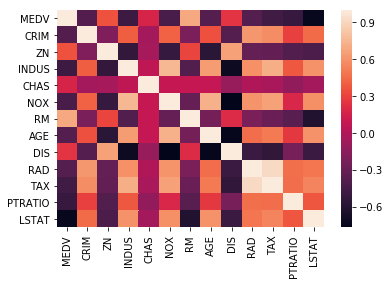

In [54]:
sns.heatmap(boston.corr())

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
feature_cols_all = boston.columns.drop(['MEDV'])
X = boston[feature_cols_all]
y = boston.MEDV
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print(metrics.mean_squared_error(y, y_pred))

22.44304249125963


In [56]:
print(lr.intercept_)
print(lr.coef_)

41.69795101129759
[-1.19615762e-01  4.69055158e-02  1.37963626e-02  2.84495457e+00
 -1.87943852e+01  3.65111680e+00  3.70628288e-03 -1.49043734e+00
  2.88259456e-01 -1.26785144e-02 -9.38088171e-01 -5.53331515e-01]


In [57]:
from sklearn.linear_model import LinearRegression
feature_cols = ['CRIM', 'AGE', 'TAX', 'DIS']
X = boston[feature_cols]
y = boston['MEDV']
lr = LinearRegression()
lr.fit(X, y)
from sklearn import metrics
y_pred = lr.predict(X)
print(metrics.mean_squared_error(y, y_pred))

#mean squared error is greater when only testing subset of features compared to all features

60.42542319891321


In [58]:
print(lr.intercept_)
print(lr.coef_)

41.71887105210194
[-0.17980214 -0.10616674 -0.01808962 -1.02098245]


In [59]:
list(zip(feature_cols, lr.coef_))

[('CRIM', -0.17980214467416974),
 ('AGE', -0.10616673788369285),
 ('TAX', -0.018089615866847885),
 ('DIS', -1.020982450709317)]

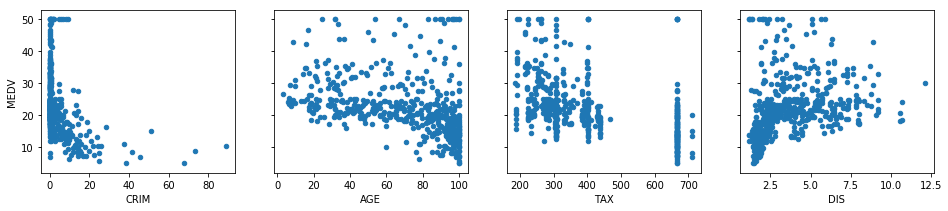

In [60]:
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    boston.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(16, 3))

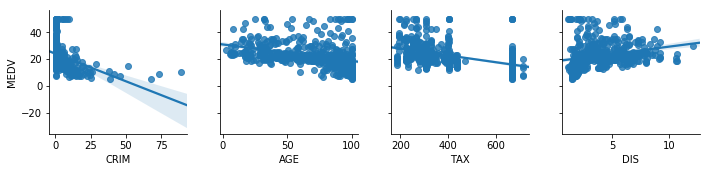

In [61]:
sns.pairplot(boston, x_vars=feature_cols, y_vars='MEDV', kind='reg');

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

59.34073523748051
63.60973599777664


In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=123)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

#mean squared error improves when more data is used for training instead of testing

54.90980354009967
111.31133629621789


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [64]:
#Accuracy goes down with n = 10 compared to n = 5 ; variance decreases while bias increases as number of folds increase
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True)
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 71.95743917565653
R2: 0.28160208743679815

Model 2
MSE: 48.96139248209915
R2: 0.28298832115601125

Model 3
MSE: 54.38618654240553
R2: 0.279983910437381

Model 4
MSE: 49.29285747453835
R2: 0.2829267554169903

Model 5
MSE: 86.29576424198918
R2: 0.28174042658117504

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 62.17872798333775
Mean of R2 for all folds: 0.2818483002056712


In [65]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True)
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 64.16122293617701
R2: 0.28305579166345163

Model 2
MSE: 66.49697133305874
R2: 0.28365500691921086

Model 3
MSE: 58.951683980169655
R2: 0.2839370439490678

Model 4
MSE: 75.32845379270046
R2: 0.28406913142174717

Model 5
MSE: 38.65500530690884
R2: 0.283915426644468

Model 6
MSE: 54.674805563824236
R2: 0.28375549611006856

Model 7
MSE: 98.69216897970438
R2: 0.2830984237575477

Model 8
MSE: 57.24314475471117
R2: 0.28372244511126576

Model 9
MSE: 57.00826591727212
R2: 0.2835247099670918

Model 10
MSE: 43.17215568977413
R2: 0.2832618462596447

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 61.438387825430084
Mean of R2 for all folds: 0.2835995321803564


# KNN Practice

In [66]:
# Read the iris data into a DataFrame
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [67]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [68]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [69]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

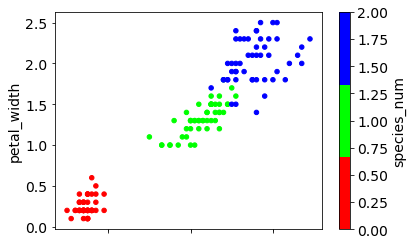

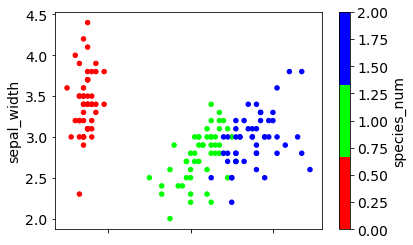

In [70]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold);
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [71]:
feature_cols = ['sepal_length', 'sepal_width','petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [72]:
y = iris.species

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [74]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [75]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.8947368421052632


### Create a Model With Five Neighbors. Did it Improve?

In [76]:
# Five neighbors gives greater accuracy than n = 1
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9736842105263158


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

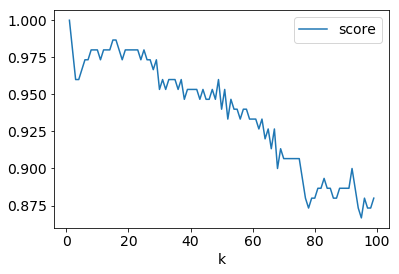

In [77]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

In [78]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [79]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)
    
# Create a DataFrame of K, training error, and testing error.
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
100,0.666667,0.789474
99,0.666667,0.789474
98,0.666667,0.789474
97,0.666667,0.789474
96,0.666667,0.789474


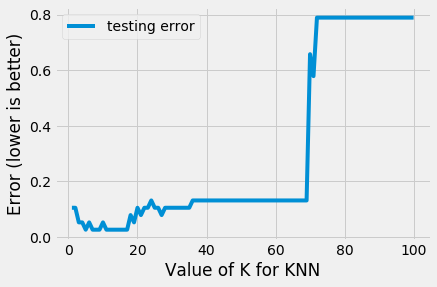

In [80]:
# Plot the relationship between K (HIGH TO LOW) and TESTING ERROR.
plt.style.use('fivethirtyeight')
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

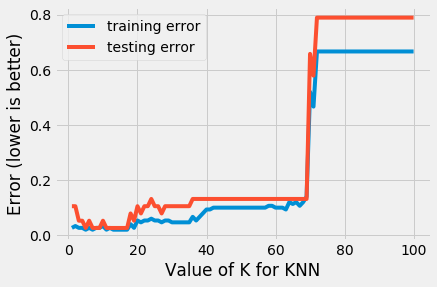

In [81]:
# Plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR.
df.plot();
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [82]:
#Returns probability estimates for the test data X.
print (knn.predict_proba(X))

[[0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.34 0.42 0.24]
 [0.22 0.42 0.36]
 [0.22 0.42 0.36]
 [0.22 0.42 0.36]
 [0.26 0.42 0.32]
 [0.22 0.42 0.36]
 [0.22 0.4

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [86]:
# First, format our data in a DataFrame
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [87]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 24 Mar 2019   Prob (F-statistic):          1.59e-321
Time:                        18:07:37   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [88]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [89]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [90]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.12682609241128115
